# 2_2 Task - Pablo Muñoz Alcaide

The purpose of this task is to determine the procedure to obtain the 3D coordinates of a point P 
that can be observed in two images. For simplicity, consider that the images are provided by two 
cameras mounted on a stereo rig, and that distances between the cameras are known.

## Explanation

The process of determining the 3D coordinates of a point P that can be observed in two images is called Stereo triangulation. This process involves finding corresponding poins in the images and then calculating the 3D coordinates of those points.

## Pseudo Algorithm 

1. **Camera Calibration** The first step is known as camera calibration. Which is basically to determine the intrinsic parameters of the camera (focal length, principal point, lens distortion parameters and intrinsic matrix), and the extrinsic parameters with respect to the world coordinate system. (Rotation matrix, translation vector t, Extrinsic Matrix). This could be done using a calibration pattern, like a checkerboard.

2. **Stereo Rectification (Optional)**  Adjust the images to ensure that the epipolar lines are aligned horizontally.

3. **Feature Matching** Identify corresponding points in the rectified images, SIFT algorithm is often used to find the distinctive keypoints in both images and stablish the correspondences between them.

4. **Stereo Correspondence** Given the feature matches and the epipolar geometry, establish correspondences between points in the left and right images. This step involves finding the disparity, which is the horizontal difference between the matched points.

5. **Triangulation** This process involves using the camera projection matrices and the disparity information to calculate the 3D position of each point.

# Python Computations

In [26]:
try:
    import google.colab
    print('Running on CoLab')
    !pip install matplotlib
    !pip install machinevision-toolbox-python
    !pip install --no-deps rvc3python
    COLAB = True
except:
    COLAB = False

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"
from IPython.core.display import HTML

import RVC3 as rvc
import sys, os.path
sys.path.append(os.path.join(rvc.__path__[0], 'examples'))

import numpy as np
from scipy import linalg, stats
import matplotlib.pyplot as plt
import math
from math import pi
np.set_printoptions(
    linewidth=120, formatter={
        'float': lambda x: f"{0:8.4g}" if abs(x) < 1e-10 else f"{x:8.4g}"})
np.random.seed(0)
from machinevisiontoolbox.base import *
from machinevisiontoolbox import *
from spatialmath.base import *
from spatialmath import *

In [27]:
# First we read the images
view1 = Image.Read("eiffel-1.png", reduce =2)
view2 = Image.Read("eiffel-2.png", reduce =2)

Image: 640 x 480 (uint8), R:G:B [...\images\eiffel-2.png]

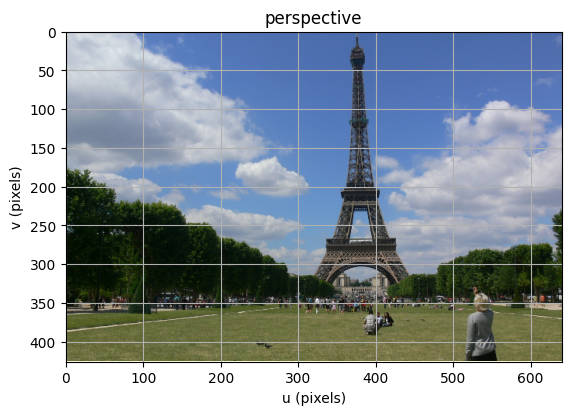

In [28]:
# Showing the images
camera = CentralCamera();
camera.disp(view1);

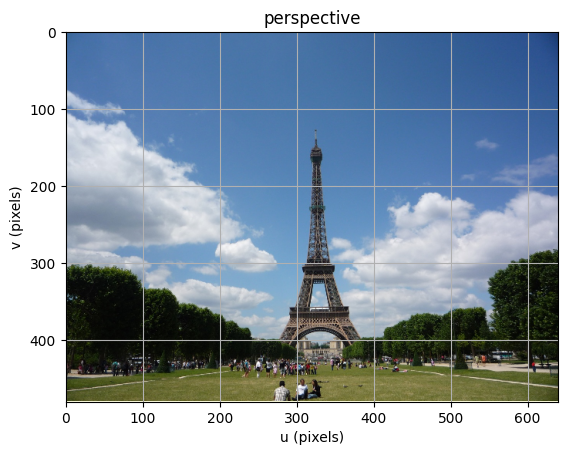

In [29]:
camera.disp(view2);

In [30]:
# Calculate the intrinsic parameters 
# which are obtained by the metadata of the image
f = view1.metadata("FocalLength")

7.4

In [31]:
name = view1.metadata("Model")

'DMC-FZ30'

In [32]:
camera = CentralCamera(name=name, imagesize=view1.shape, 
                       f=f/1000, rho=2*1.5e-6)

           Name: DMC-FZ30 [CentralCamera]
     pixel size: 3e-06 x 3e-06
     image size: 426 x 640
           pose: t = 0, 0, 0; rpy/yxz = 0°, 0°, 0°
   principal pt: [     213      320]
   focal length: [  0.0074   0.0074]

We don't have more information, so we make the assumption that the principal point is at the center of the image.

In [33]:
# Computing the SIFT features
sf_1 = view1.SIFT();
sf_2 = view2.SIFT();

In [34]:
# Finding putative matches
matches = sf_1.match(sf_2)
F, resid = matches.estimate(CentralCamera.points2F, confidence=0.99, seed=0);

In [35]:
matches = matches.inliers # keep only the inliers

198 matches, with 198 (100.0%) inliers

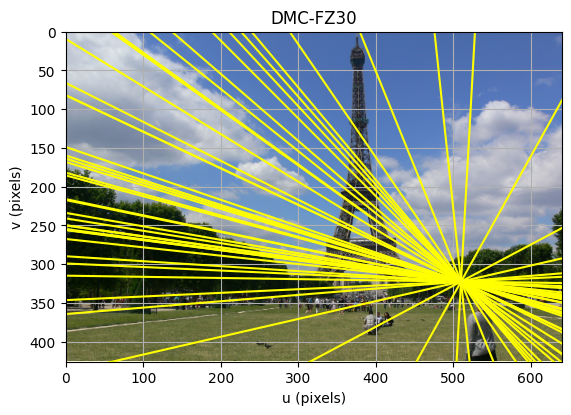

In [36]:
# Stereo correspondence

# We can show the epipolar lines for a subset of right-hand image points 
# overlaid on the left-hand image
camera.disp(view1);
camera.plot_epiline(F.T, matches.subset(40).p2, "yellow");

In [37]:
# Triangulation

#First, we calculate the essential matrix which is obtained by applying the
# intrinsic parameters to the fundamental matrix
E = camera.E(F)

array([[  0.4523,    -99.3,  0.04906],
       [   97.24,  -0.7033,   -11.71],
       [  -3.393,    9.067,   0.3993]])

In [38]:
# We decompose the essential matrix to obtain the camera motion
T_1_2 = camera.decomposeE(E, [0, 0, 10]);
T_1_2.printline(orient="camera")

t = -0.12, -0.00104, -0.993; rpy/yxz = 180°, -2.02°, 12.1°


We chose a test point P at (0, 0, 10), a distant point along the optical axis, to determine the correct solution for the relative camera motion

We also suppose that when we took the images the camera position changed by approximately 0.3m in the positive x-direction.

In [39]:
t = T_1_2.t;
s = 0.3 / t[0]  # estimate of translation scale factor
T_1_2.t = s * t  # scaled translation
T_1_2.printline(orient="camera")

t = 0.3, 0.0026, 2.49; rpy/yxz = 180°, -2.02°, 12.1°


We have estimate the relative pose of camera two with respect to
camera one represented as an $\textbf{ SE(}3\textbf{)}$. matrix

Each image-plane point corresponds to a ray in space, and
sometimes called a raxel, which we represent by a 3-dimensional line. In the first corresponding point pair, the ray from camera one is:

In [40]:
ray1 = camera.ray(matches[0].p1)

{ 0 0 0; 0.067693 -0.062177 1}

In [41]:
# The ray in the second camera frame is
ray2 = camera.ray(matches[0].p2, pose=T_1_2)

{ 0.13528 -0.11117 -0.016181; 0.16346 0.055352 0.9863}

In [42]:
# The intersection of the rays is the 3D point
P, e = ray1.closest_to_line(ray2);

In [43]:
# Due to errors in the estimate of camera two’s pose 
# the two rays do not actually intersect, but their
# closest point is returned.
P

array([ 0.07822, -0.07185,    1.156])

In [44]:
# At the closest point, the lines are nearly "e" apart. 
e

0.0007327902639626983